In [1]:
import mujoco

In [2]:
mujoco.__version__

'3.3.3'

In [ ]:
xml_string = """
<mujoco model="compliant_muscle_test">
  <!-- cmtu_integrator: Euler, RK4, ODE15s -->
  <option timestep="0.001" gravity="0 0 -9.81" integrator="Euler"/>

  <default>
    <!-- Compliant muscle default class -->
     <!-- F_max, l_opt, l_slack, v_max, W, C, N, K, E_REF -->
    <default class="compliant_muscle">
      <general biasprm="0" biastype="none" ctrllimited="true" ctrlrange="0 1" 
               dynprm="0.01 0.04" dyntype="muscle" 
               gainprm="1500 0.11 0.13 12.0 0.56 -2.995732274 1.5 5.0 0.04" 
               gaintype="compliant_mtu"/>
    </default>
    
    <!-- Standard muscle for comparison -->
    <default class="standard_muscle">
      <!-- <general biasprm="0.75 1.05 -1 400 0.5 1.6 1.5 1.3 1.2 0"  biastype="muscle" 
               ctrllimited="true" ctrlrange="0 1" 
               dynprm="0.01 0.04 0 0 0 0 0 0 0 0" dyntype="muscle" 
               gainprm="0.75 1.05 -1 400 0.5 1.6 1.5 1.3 1.2 0"
               gaintype="muscle"/> -->
      <!-- range(2), force, scale, lmin, lmax, vmax, fpmax, fvmax -->
      <general biasprm="0.1 0.5 1500 1 0 1.99579 10 1.86621 1.4 0"
               ctrllimited="true" ctrlrange="0 1" 
               dynprm="0.01 0.04 0 0 0 0 0 0 0 0" dyntype="muscle" 
               gainprm="0.1 0.5 1500 1 0 1.99579 10 1.86621 1.4 0"
               gaintype="muscle"/>
    </default>
  </default>

  <worldbody>
    <body name="ground"/>
    
    <!-- Fixed anchor sites for tendons -->
    <site name="fixed_c" pos="-0.15 0 0.24" size="0.005" rgba="0 0 1 1"/>
    <site name="fixed_r" pos="0.15 0 0.24" size="0.005" rgba="0 1 0 1"/>

    <!-- Point masses to be pulled by muscles -->
    <body name="mass_c" pos="-0.15 0 0">
      <joint name="slide_c" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0"/>
      <site name="mass_c_site" pos="0 0 0" size="0.005" rgba="0 0 1 1"/>
      <geom type="sphere" size="0.01" mass="10.0" rgba="0 0 1 1"/>
    </body>
    <body name="mass_r" pos="0.15 0 0">
      <joint name="slide_r" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0"/>
      <site name="mass_r_site" pos="0 0 0" size="0.005" rgba="0 1 0 1"/>
      <geom type="sphere" size="0.01" mass="10.0" rgba="0 1 0 1"/>
    </body>
  </worldbody>

  <!-- Tendon paths for muscles: fixed anchor to point mass site -->
  <tendon>
    <spatial name="tendon_c">
      <site site="fixed_c"/>
      <site site="mass_c_site"/>
    </spatial>
    <spatial name="tendon_r">
      <site site="fixed_r"/>
      <site site="mass_r_site"/>
    </spatial>
  </tendon>

  <actuator>
    <!-- Compliant muscle pulling left point mass -->
    <general class="compliant_muscle" name="compliant_muscle_c" tendon="tendon_c"/>
    
    <!-- Standard muscle pulling right point mass (for comparison) -->
    <muscle class="standard_muscle" name="standard_muscle_r" tendon="tendon_r" 
            lengthrange="0.0575158 0.156738"/>
  </actuator>

  <sensor>
    <!-- Tendon length sensors -->
    <tendonpos name="len_c" tendon="tendon_c"/>
    <tendonpos name="len_r" tendon="tendon_r"/>
    
    <!-- Actuator force sensors -->
    <actuatorfrc name="frc_c" actuator="compliant_muscle_c"/>
    <actuatorfrc name="frc_r" actuator="standard_muscle_r"/>
    
    <!-- Joint position sensors -->
    <jointpos name="pos_c" joint="slide_c"/>
    <jointpos name="pos_r" joint="slide_r"/>
    
    <!-- Joint velocity sensors -->
    <jointvel name="vel_c" joint="slide_c"/>
    <jointvel name="vel_r" joint="slide_r"/>
  </sensor>
</mujoco>


"""

# Free fall

In [4]:
model = mujoco.MjModel.from_xml_string(xml_string)
data = mujoco.MjData(model)

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)
ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)
frames = []
for idx in range(120):
    for simulation_step in range(40):
        mujoco.mj_step(model, data)
    renderer.update_scene(data)
    frame = renderer.render()
    frames.append(frame.copy())  # Important: copy the frame!
renderer.close()

import imageio
video_path = "free_fall.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))



# Activate

In [5]:
model = mujoco.MjModel.from_xml_string(xml_string)
data = mujoco.MjData(model)

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)
ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)
datas = {}

for ui in range(model.nu):
    datas[f'ctrl_{ui}'] = []
for ji in range(model.njnt):
    datas[f'qpos_{ji}'] = []
for ji in range(model.njnt):
    datas[f'qvel_{ji}'] = []
for fi in range(model.nu):
    datas[f'frc_{fi}'] = []

frames = []
for idx in range(120):
    # Activate both at t=1s (frame 30), deactivate at t=2s (frame 60)
    # Assume actuator 0 and 1, and setting ctrl to 1.0 to "activate"
    if idx == 30:
        data.ctrl[0] = 1.0
        data.ctrl[1] = 1.0
    elif idx == 60:
        data.ctrl[0] = 0.0
        data.ctrl[1] = 0.0
    for simulation_step in range(40):
        mujoco.mj_step(model, data)

        # collect data

        for ui in range(model.nu):
            datas[f'ctrl_{ui}'].append(data.ctrl[ui])
        for ji in range(model.njnt):
            datas[f'qpos_{ji}'].append(data.qpos[ji])
        for ji in range(model.njnt):
            datas[f'qvel_{ji}'].append(data.qvel[ji])
        for fi in range(model.nu):
            datas[f'frc_{fi}'].append(data.qfrc_actuator[fi])


    renderer.update_scene(data)
    frame = renderer.render()
    frames.append(frame.copy())  # Important: copy the frame!
renderer.close()
import imageio
video_path = "activate.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))


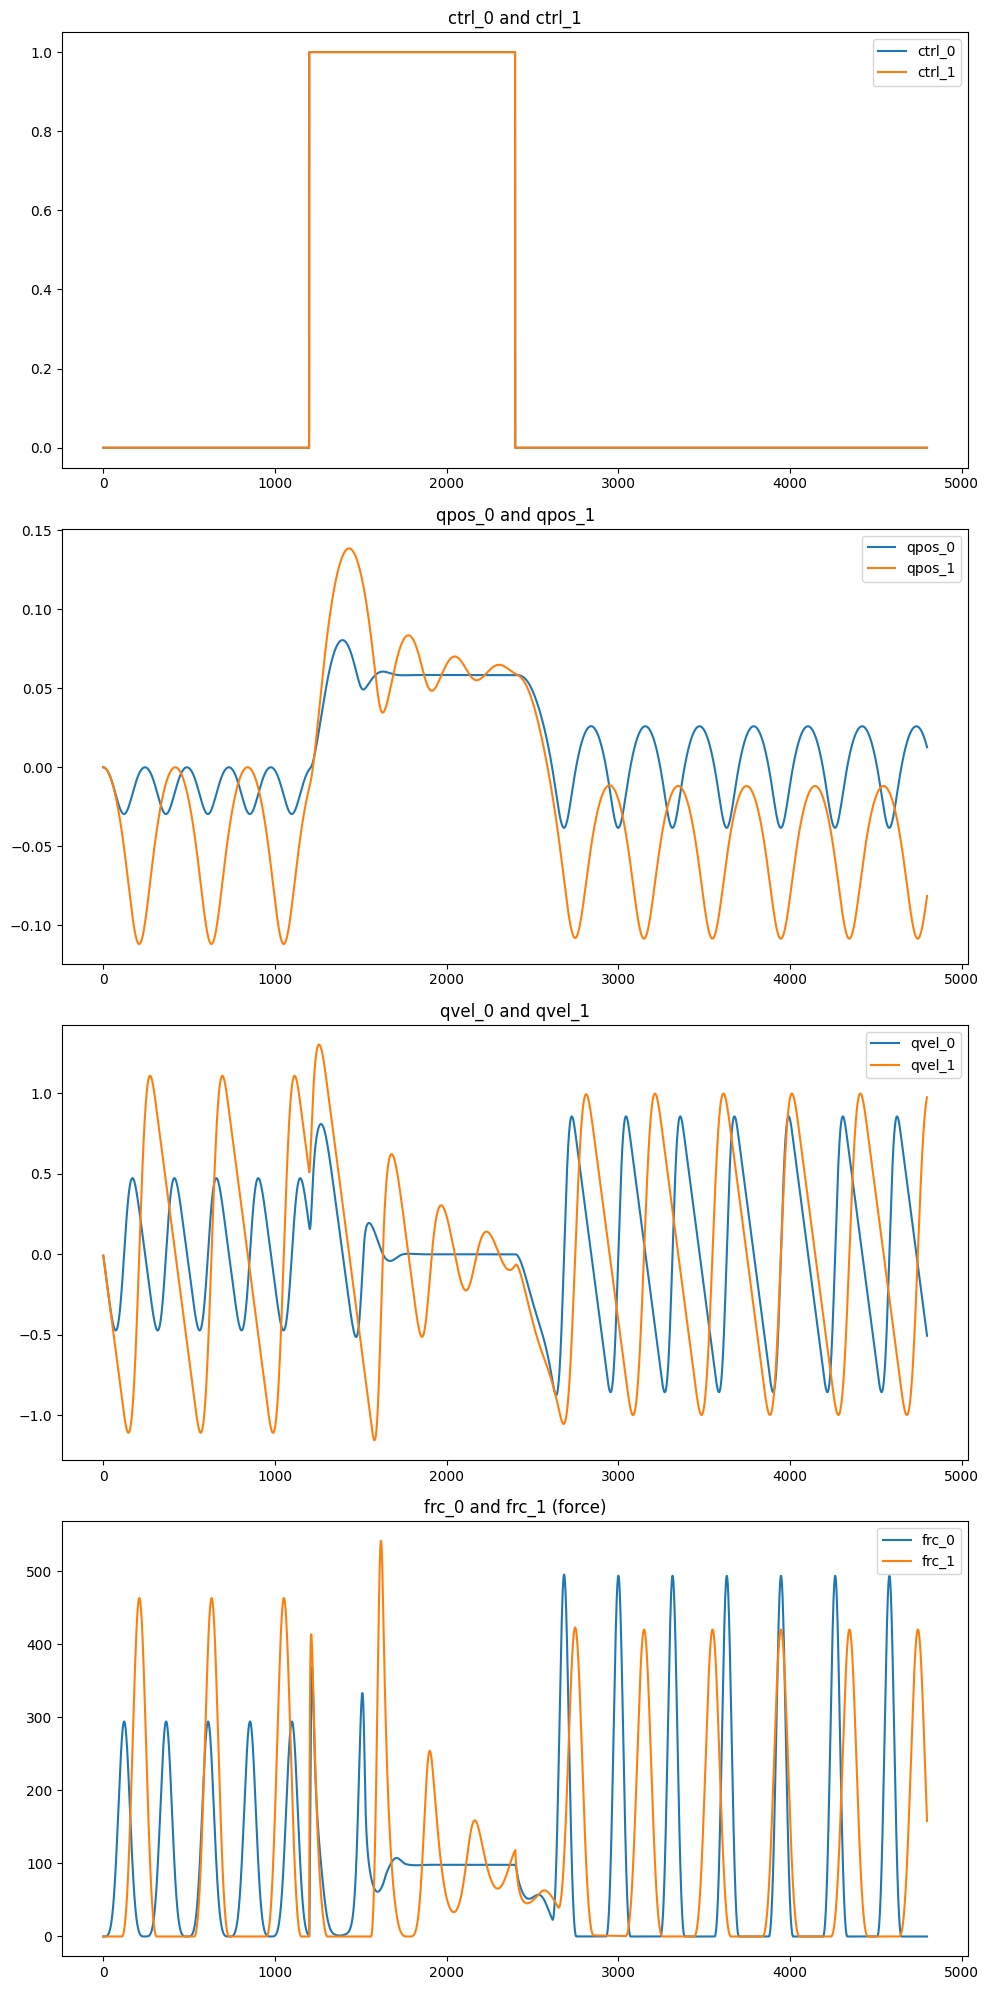

In [6]:
import matplotlib.pyplot as plt

# Group ctrl_0 and ctrl_1; qpos_0 and qpos_1; qvel_0 and qvel_1 together
ctrl_keys = [k for k in datas if k.startswith("ctrl_")]
qpos_keys = [k for k in datas if k.startswith("qpos_")]
qvel_keys = [k for k in datas if k.startswith("qvel_")]
frc_keys = [k for k in datas if k.startswith("frc_")]

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot ctrl_0 and ctrl_1 in one plot
for k in ["ctrl_0", "ctrl_1"]:
    if k in datas:
        axs[0].plot(datas[k], label=k)
axs[0].set_title("ctrl_0 and ctrl_1")
axs[0].legend()

# Plot qpos_0 and qpos_1 in one plot
for k in ["qpos_0", "qpos_1"]:
    if k in datas:
        axs[1].plot(datas[k], label=k)
axs[1].set_title("qpos_0 and qpos_1")
axs[1].legend()

# Plot qvel_0 and qvel_1 in one plot
for k in ["qvel_0", "qvel_1"]:
    if k in datas:
        axs[2].plot(datas[k], label=k)
axs[2].set_title("qvel_0 and qvel_1")
axs[2].legend()

# Plot frc_0 and frc_1 in one plot (force)
for k in ["frc_0", "frc_1"]:
    if k in datas:
        axs[3].plot(datas[k], label=k)
axs[3].set_title("frc_0 and frc_1 (force)")
axs[3].legend()

plt.tight_layout()
plt.show()


# Activate multiple steps

In [7]:
model = mujoco.MjModel.from_xml_string(xml_string)
data = mujoco.MjData(model)

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)
ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)
datas = {}

for ui in range(model.nu):
    datas[f'ctrl_{ui}'] = []
for ji in range(model.njnt):
    datas[f'qpos_{ji}'] = []
for ji in range(model.njnt):
    datas[f'qvel_{ji}'] = []
for fi in range(model.nu):
    datas[f'frc_{fi}'] = []

total_frames = 120
ctrl_max = 1.0

rise_frames = 30
hold_frames = 30
fall_frames = 30

frames = []
for idx in range(total_frames):

    if idx < rise_frames:
        ctrl_val = ctrl_max * (idx / rise_frames)

    elif rise_frames <= idx < rise_frames + hold_frames:
        ctrl_val = ctrl_max

    elif rise_frames + hold_frames <= idx < rise_frames + hold_frames + fall_frames:
        ctrl_val = ctrl_max * (1 - ((idx - rise_frames - hold_frames) / fall_frames))

    else:
        ctrl_val = 0.0

    for act_idx in range(model.nu):
        data.ctrl[act_idx] = ctrl_val

    for simulation_step in range(40):
        mujoco.mj_step(model, data)

        # collect data
        for ui in range(model.nu):
            datas[f'ctrl_{ui}'].append(data.ctrl[ui])
        for ji in range(model.njnt):
            datas[f'qpos_{ji}'].append(data.qpos[ji])
        for ji in range(model.njnt):
            datas[f'qvel_{ji}'].append(data.qvel[ji])
        for fi in range(model.nu):
            datas[f'frc_{fi}'].append(data.qfrc_actuator[fi])

    renderer.update_scene(data)
    frame = renderer.render()
    frames.append(frame.copy())  # Important: copy the frame!
renderer.close()

import imageio
video_path = "activate.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))

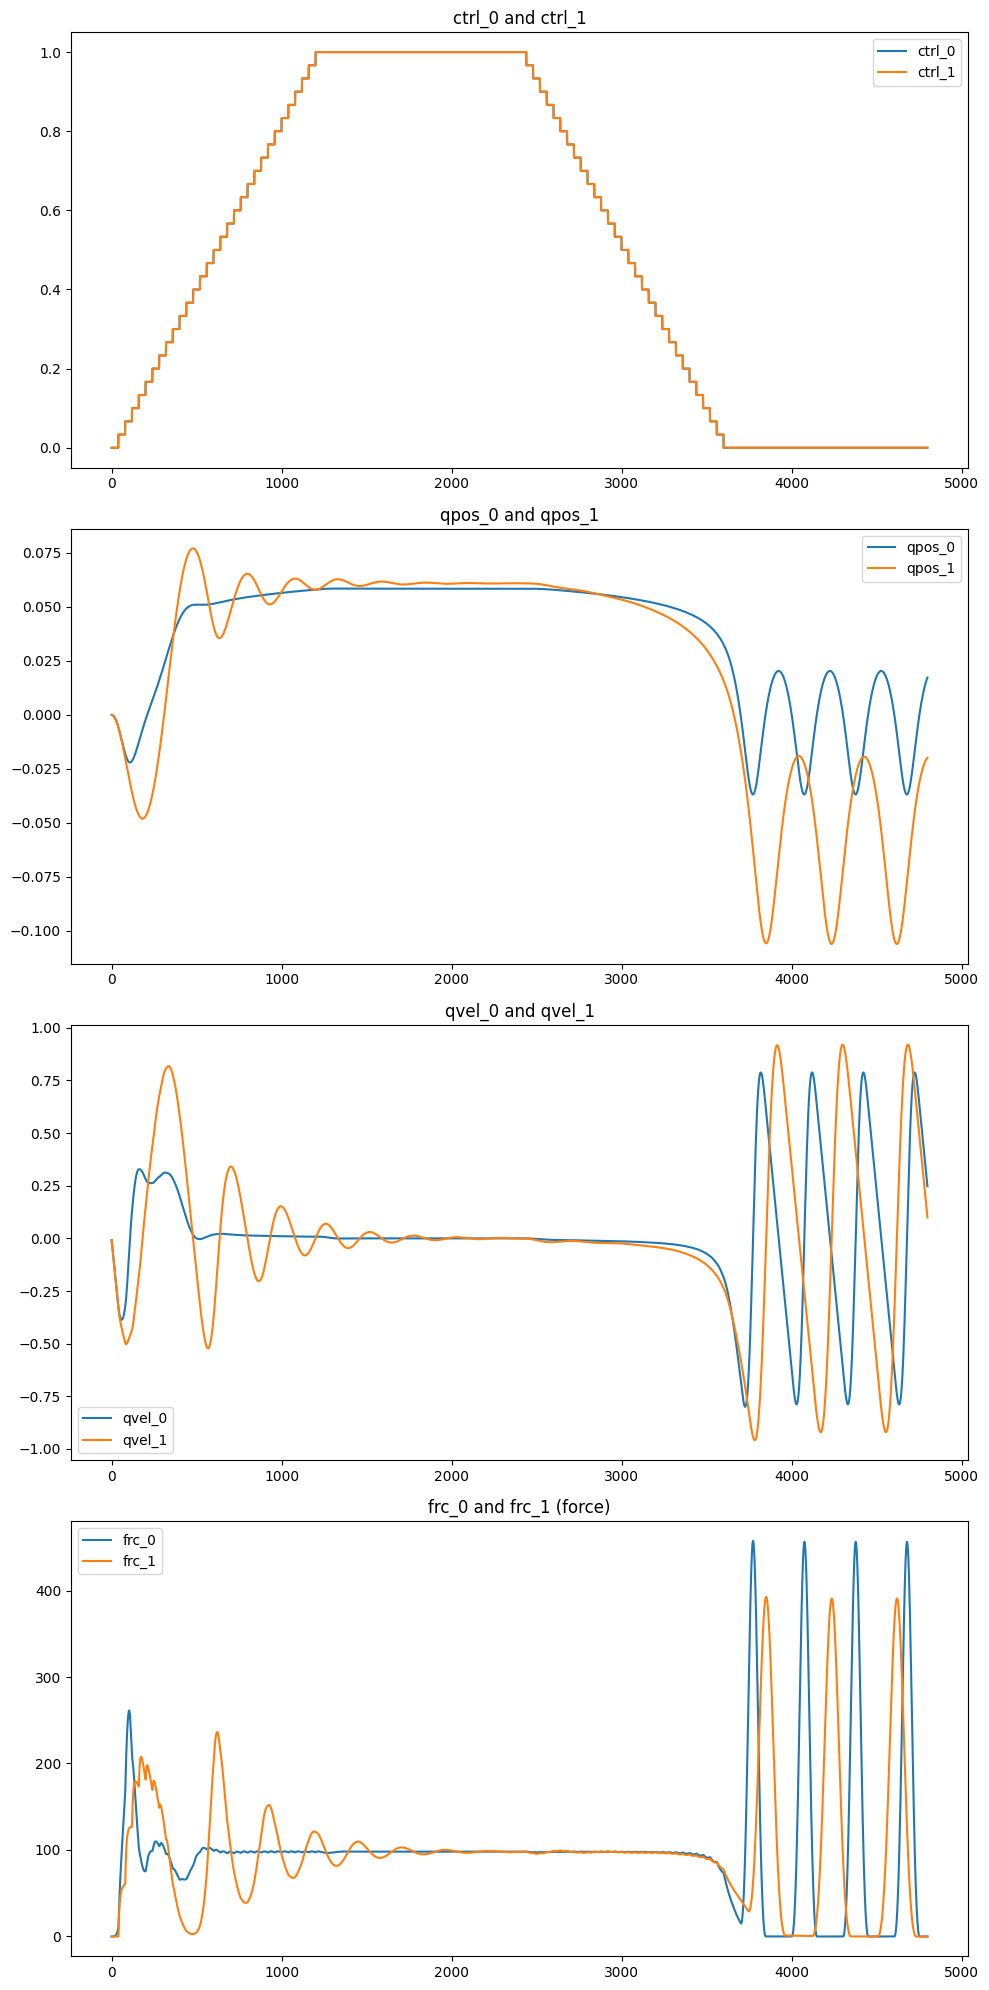

In [8]:
import matplotlib.pyplot as plt

# Group ctrl_0 and ctrl_1; qpos_0 and qpos_1; qvel_0 and qvel_1 together
ctrl_keys = [k for k in datas if k.startswith("ctrl_")]
qpos_keys = [k for k in datas if k.startswith("qpos_")]
qvel_keys = [k for k in datas if k.startswith("qvel_")]
frc_keys = [k for k in datas if k.startswith("frc_")]

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot ctrl_0 and ctrl_1 in one plot
for k in ["ctrl_0", "ctrl_1"]:
    if k in datas:
        axs[0].plot(datas[k], label=k)
axs[0].set_title("ctrl_0 and ctrl_1")
axs[0].legend()

# Plot qpos_0 and qpos_1 in one plot
for k in ["qpos_0", "qpos_1"]:
    if k in datas:
        axs[1].plot(datas[k], label=k)
axs[1].set_title("qpos_0 and qpos_1")
axs[1].legend()

# Plot qvel_0 and qvel_1 in one plot
for k in ["qvel_0", "qvel_1"]:
    if k in datas:
        axs[2].plot(datas[k], label=k)
axs[2].set_title("qvel_0 and qvel_1")
axs[2].legend()

# Plot frc_0 and frc_1 in one plot (force)
for k in ["frc_0", "frc_1"]:
    if k in datas:
        axs[3].plot(datas[k], label=k)
axs[3].set_title("frc_0 and frc_1 (force)")
axs[3].legend()

plt.tight_layout()
plt.show()
